In [188]:
import pandas as pd
import pickle
df_seoul = pd.read_pickle('seoul_신한카드.pkl')
df_dong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 행정동코드', skiprows=1)
df_upjong_code = pd.read_excel('2020빅콘테스트 문제데이터(혁신아이디어분야)/02_카드매출데이터(신한카드)/02_혁신아이디어분야_카드소비데이터(신한카드)_데이터정의서.xlsx',
                            sheet_name='(참고) 업종코드', skiprows=1)
df_upjong_code = df_upjong_code[['업종코드 (32개 분류)']]
df_upjong_code.dropna(inplace=True)

In [195]:
#20대만보기위해 필터링
df_seoul = df_seoul.query('나이코드 in [20,25]')
df_seoul = df_seoul.query('Year==2020 or (Year==2019 and 이용건수>100)')
df_seoul

,기준일자,행정동코드,업종코드,성별코드,나이코드,이용건수,이용금액,건별 이용금액,시_구,행정동,업종,Year,Month
구코드,,,,,,,,,,,,,
140,2019-02-01,520,40,F,20,2861,73680,25.8,서울 중구,소공동,유통업,2019,2
140,2019-02-01,520,40,F,25,8276,205123,24.8,서울 중구,소공동,유통업,2019,2
140,2019-02-01,520,40,M,20,850,20555,24.2,서울 중구,소공동,유통업,2019,2
140,2019-02-01,520,40,M,25,3494,133975,38.3,서울 중구,소공동,유통업,2019,2
140,2019-02-01,520,62,F,25,154,1262,8.2,서울 중구,소공동,자동차정비,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,2020-05-31,720,80,M,20,61,702,11.5,서울 노원구,상계10동,요식업소,2020,5
350,2020-05-31,720,80,M,25,94,1209,12.9,서울 노원구,상계10동,요식업소,2020,5
350,2020-05-31,720,81,F,20,5,51,10.2,서울 노원구,상계10동,음료식품,2020,5


In [196]:
pd.options.display.float_format = '{:.1f}'.format

In [197]:
df_dong_code = df_dong_code[:34]

In [198]:
import re
upjong_dic={}
gu_dic={}
gu_dong_dic={}
for i, j in zip(df_dong_code['구코드'], df_dong_code['구명']):
    gu_dic[i]=j
for i, j, x, y in zip(df_dong_code['구코드'], df_dong_code['구명'], df_dong_code['행정동코드'], df_dong_code['행정동명']):
    gu_dong_dic[(i,x)]=y
for i in df_upjong_code.values:
    key = re.findall('\((.*)\)',i[0])[0]
    val = re.findall('(.*)\(',i[0])[0]
    upjong_dic[key]=val

In [199]:
#type 바꿔주기
df_seoul['기준일자'] = df_seoul['기준일자'].astype(str)
df_seoul['기준일자'] = pd.to_datetime(df_seoul['기준일자'])
df_seoul['업종코드'] = df_seoul['업종코드'].astype(str)

#시구, 동, 업종코드 mapping
df_seoul['시_구'] = df_seoul.index.map(gu_dic)
df_seoul['행정동'] = [gu_dong_dic[(i,x)] for i,x in zip(df_seoul.index, df_seoul['행정동코드'])]
df_seoul['업종'] = df_seoul['업종코드'].map(upjong_dic)

In [200]:
df_seoul['Year'] = df_seoul['기준일자'].dt.year
df_seoul['Month'] = df_seoul['기준일자'].dt.month

구별 (업종별, 성별, 나이별, (이용금액,건수))
140:중구, 350:노원구

In [201]:
df_seoul['행정동코드'].unique()

array([520, 540, 550, 570, 580, 590, 605, 615, 625, 635, 645, 650, 665,
       670, 680, 560, 595, 600, 611, 612, 619, 621, 624, 630, 640, 695,
       700, 710, 720], dtype=int64)

In [202]:
df_set={}

In [203]:
df_0 = df_seoul[['시_구','업종','Year','이용건수','이용금액']].groupby(['시_구','업종','Year']).mean()

In [204]:
df_1 = df_seoul.query('업종 not in ["의료기관", "보건위생", "자동차정비"]')

df_1 = df_1[['시_구','행정동','업종','Year','Month','이용건수','이용금액']].groupby(['시_구','행정동','Month','업종','Year']).mean()
test = df_1.reset_index().set_index(['시_구','행정동','Month','업종'])
#2019가 없는 항목은 제외시키기
for i in test.index:
    if len(test.loc[i])!=2:
        test.drop(i,inplace=True)
df_1 = test.reset_index().set_index(['시_구','행정동','Month','업종','Year'])


In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
def gu_dong(gu, dong):
    for m in df_seoul.Month.unique():
        if m == 2:
            df_2 = df_1.loc[gu,dong,m].T  
            ##여기에다가 이용건수에대한 threshold 주면좋을듯 
            
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new = pd.DataFrame(a)
            df_new.columns = ['2월']
        
        else : 
            df_2 = df_1.loc[gu,dong,m].T
            a=(df_2.xs(2020,level=1,axis=1).loc['이용금액'] - df_2.xs(2019,level=1,axis=1).loc['이용금액'])/df_2.xs(2019,level=1,axis=1).loc['이용금액']*100
            df_new['{}월'.format(m)] = a
    print(gu, dong)        
    print(df_1.loc[gu,dong])
    df_new = df_new.stack().reset_index()
    df_new.columns = ['업종','월','전년대비_변화율']
    sns.barplot(data = df_new, x = '업종', y = '전년대비_변화율', hue='월')
    plt.ylim(-100, 100)
    plt.grid(which='major', axis='y') 
    plt.title(dong, {'fontsize' : 25, 'color':'black'})
    

In [206]:
print(len(df_seoul[df_seoul['시_구']=='서울 중구']['행정동'].unique()))
print(len(df_seoul[df_seoul['시_구']=='서울 노원구']['행정동'].unique()))

15
19


In [207]:
def makefigure(gu):
    Fig=plt.figure(figsize=(20,50))
    for i,dong in enumerate(df_seoul[df_seoul['시_구']==gu]['행정동'].unique()):
        Fig.add_subplot(ceil(len(df_seoul[df_seoul['시_구']==gu]['행정동'].unique())/2),2,i+1) 
        gu_dong(gu, dong)
    Fig.tight_layout()
    Fig.show()
    figure_dir = './img'
    import os
    if os.path.isdir(figure_dir) == False:
        os.mkdir(figure_dir)
    Fig.savefig(figure_dir+'/{}전년대비이용금액.png'.format(gu))
    Fig.show()

서울 중구 소공동
                   이용건수     이용금액
Month 업종   Year                 
2     사무통신 2019   114.7    728.7
           2020    37.7    243.8
      숙박   2019   122.0  12958.0
           2020    25.7   2488.9
      요식업소 2019 14810.6 112766.3
           2020 14096.5 105824.0
      유통업  2019  3257.6  83913.7
           2020  2326.9  60376.3
      음료식품 2019   161.7   1200.1
           2020    73.0    496.7
3     사무통신 2019   422.4   1992.5
           2020    39.9    307.0
      숙박   2019   114.0  19534.0
           2020    25.2   2725.9
      요식업소 2019 15793.6 118919.0
           2020 14233.8 103916.1
      유통업  2019  3444.8  84928.2
           2020  2165.7  59177.7
      음료식품 2019   166.8   1225.8
           2020    70.1    478.9
4     문화취미 2019   126.8   1327.5
           2020    12.8    163.1
      사무통신 2019   307.8    988.9
           2020    41.4    267.2
      숙박   2019   128.0   7077.0
           2020    26.7   2405.7
      요식업소 2019 16267.5 115479.0
           2020 15097.6 107848.8


서울 중구 약수동
                 이용건수   이용금액
Month 업종   Year             
2     레저업소 2019 161.1  999.5
           2020  72.0  492.6
      요식업소 2019 185.6 2488.3
           2020 133.7 1883.2
      유통업  2019 236.4 1620.1
           2020 208.5 1400.8
3     레저업소 2019 152.8  851.8
           2020  64.2  488.0
      요식업소 2019 191.3 2562.1
           2020 124.9 1814.4
      유통업  2019 236.6 1551.9
           2020 199.9 1295.5
4     레저업소 2019 150.8  858.7
           2020  57.6  378.0
      요식업소 2019 190.9 2219.2
           2020 141.8 2016.6
      유통업  2019 245.0 1518.6
           2020 202.4 1290.9
5     레저업소 2019 137.4  944.1
           2020  56.0  468.8
      요식업소 2019 193.4 2354.5
           2020 142.9 2077.5
      유통업  2019 237.9 1480.6
           2020 222.7 1415.6
서울 중구 청구동
                 이용건수   이용금액
Month 업종   Year             
2     레저업소 2019 140.1 1250.4
           2020  50.9  261.1
      요식업소 2019 160.4 2302.9
           2020 118.1 1750.9
      유통업  2019 156.8  992.4
           2020 136.1 1

C:\Users\YOON\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys
C:\Users\YOON\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


서울 노원구 월계1동
                   이용건수    이용금액
Month 업종    Year               
2     레저업소  2019  374.9  2222.2
            2020  277.6  1793.7
      요식업소  2019  527.0  7103.7
            2020  459.7  6070.2
      유통업   2019  524.7  3165.5
            2020  449.5  2838.9
      음료식품  2019  110.5   455.0
            2020   35.6   257.1
3     레저업소  2019  402.7  2368.8
            2020  215.7  1500.2
      서적문구  2019  232.1  5749.9
            2020   13.0   279.6
      수리서비스 2019  118.2   329.0
            2020    6.1   154.5
      연료판매  2019  104.0  2704.0
            2020   17.9   538.8
      요식업소  2019 1063.5 11112.9
            2020  460.7  5841.2
      유통업   2019  850.5  4415.1
            2020  453.9  3046.8
      음료식품  2019  148.8   730.1
            2020   31.3   227.9
4     레저업소  2019  371.1  2031.0
            2020  198.2  1493.2
      사무통신  2019  110.0    11.0
            2020   11.1   134.2
      수리서비스 2019  101.0   224.0
            2020    5.0    53.1
      연료판매  2019  101.0  354

서울 노원구 중계2.3동
                 이용건수   이용금액
Month 업종   Year             
2     문화취미 2019 123.1 1214.4
           2020  38.2  345.7
      요식업소 2019 189.6 2502.5
           2020 154.7 1941.2
      유통업  2019 457.6 7800.7
           2020 395.0 5856.5
      음료식품 2019 108.0  781.0
           2020  33.8  257.3
3     문화취미 2019 123.4 1160.6
           2020  14.4  128.4
      요식업소 2019 183.2 2325.5
           2020 143.0 1636.0
      유통업  2019 444.5 8838.5
           2020 379.1 6035.2
4     문화취미 2019 165.3 1446.8
           2020   8.0   75.9
      요식업소 2019 186.2 2068.0
           2020 150.4 1716.3
      유통업  2019 442.8 6743.5
           2020 420.0 6489.2
      음료식품 2019 105.0  708.0
           2020  30.4  236.2
5     문화취미 2019 125.7 1157.8
           2020  11.7  142.2
      요식업소 2019 189.3 2308.8
           2020 159.1 2023.5
      유통업  2019 473.1 7670.7
           2020 463.6 7875.7
      음료식품 2019 117.5 1325.5
           2020  33.0  284.0
서울 노원구 상계1동
                 이용건수   이용금액
Month 업종   Year  

C:\Users\YOON\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys
C:\Users\YOON\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


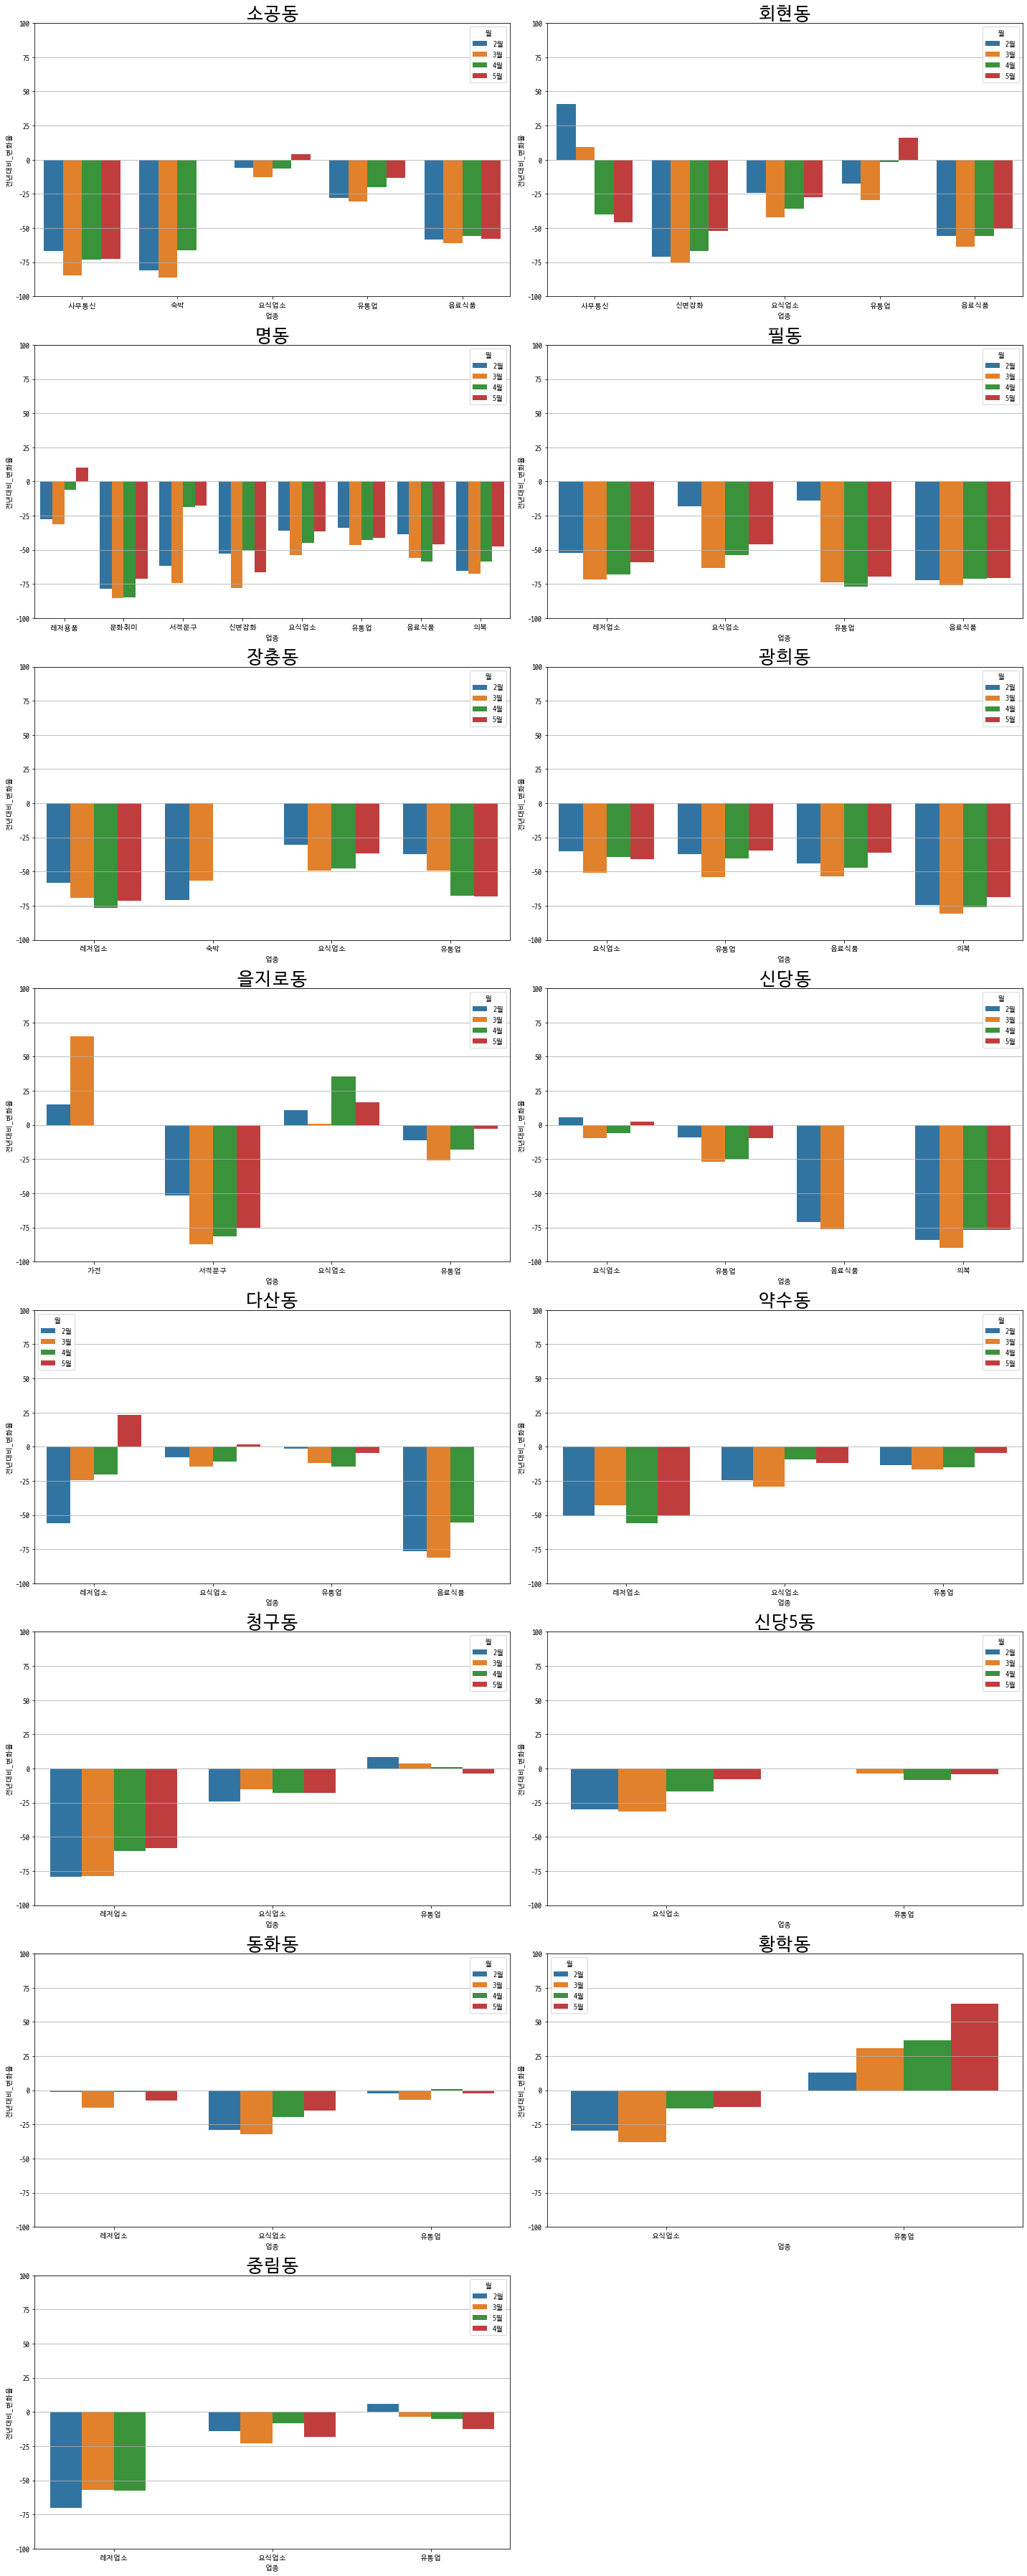

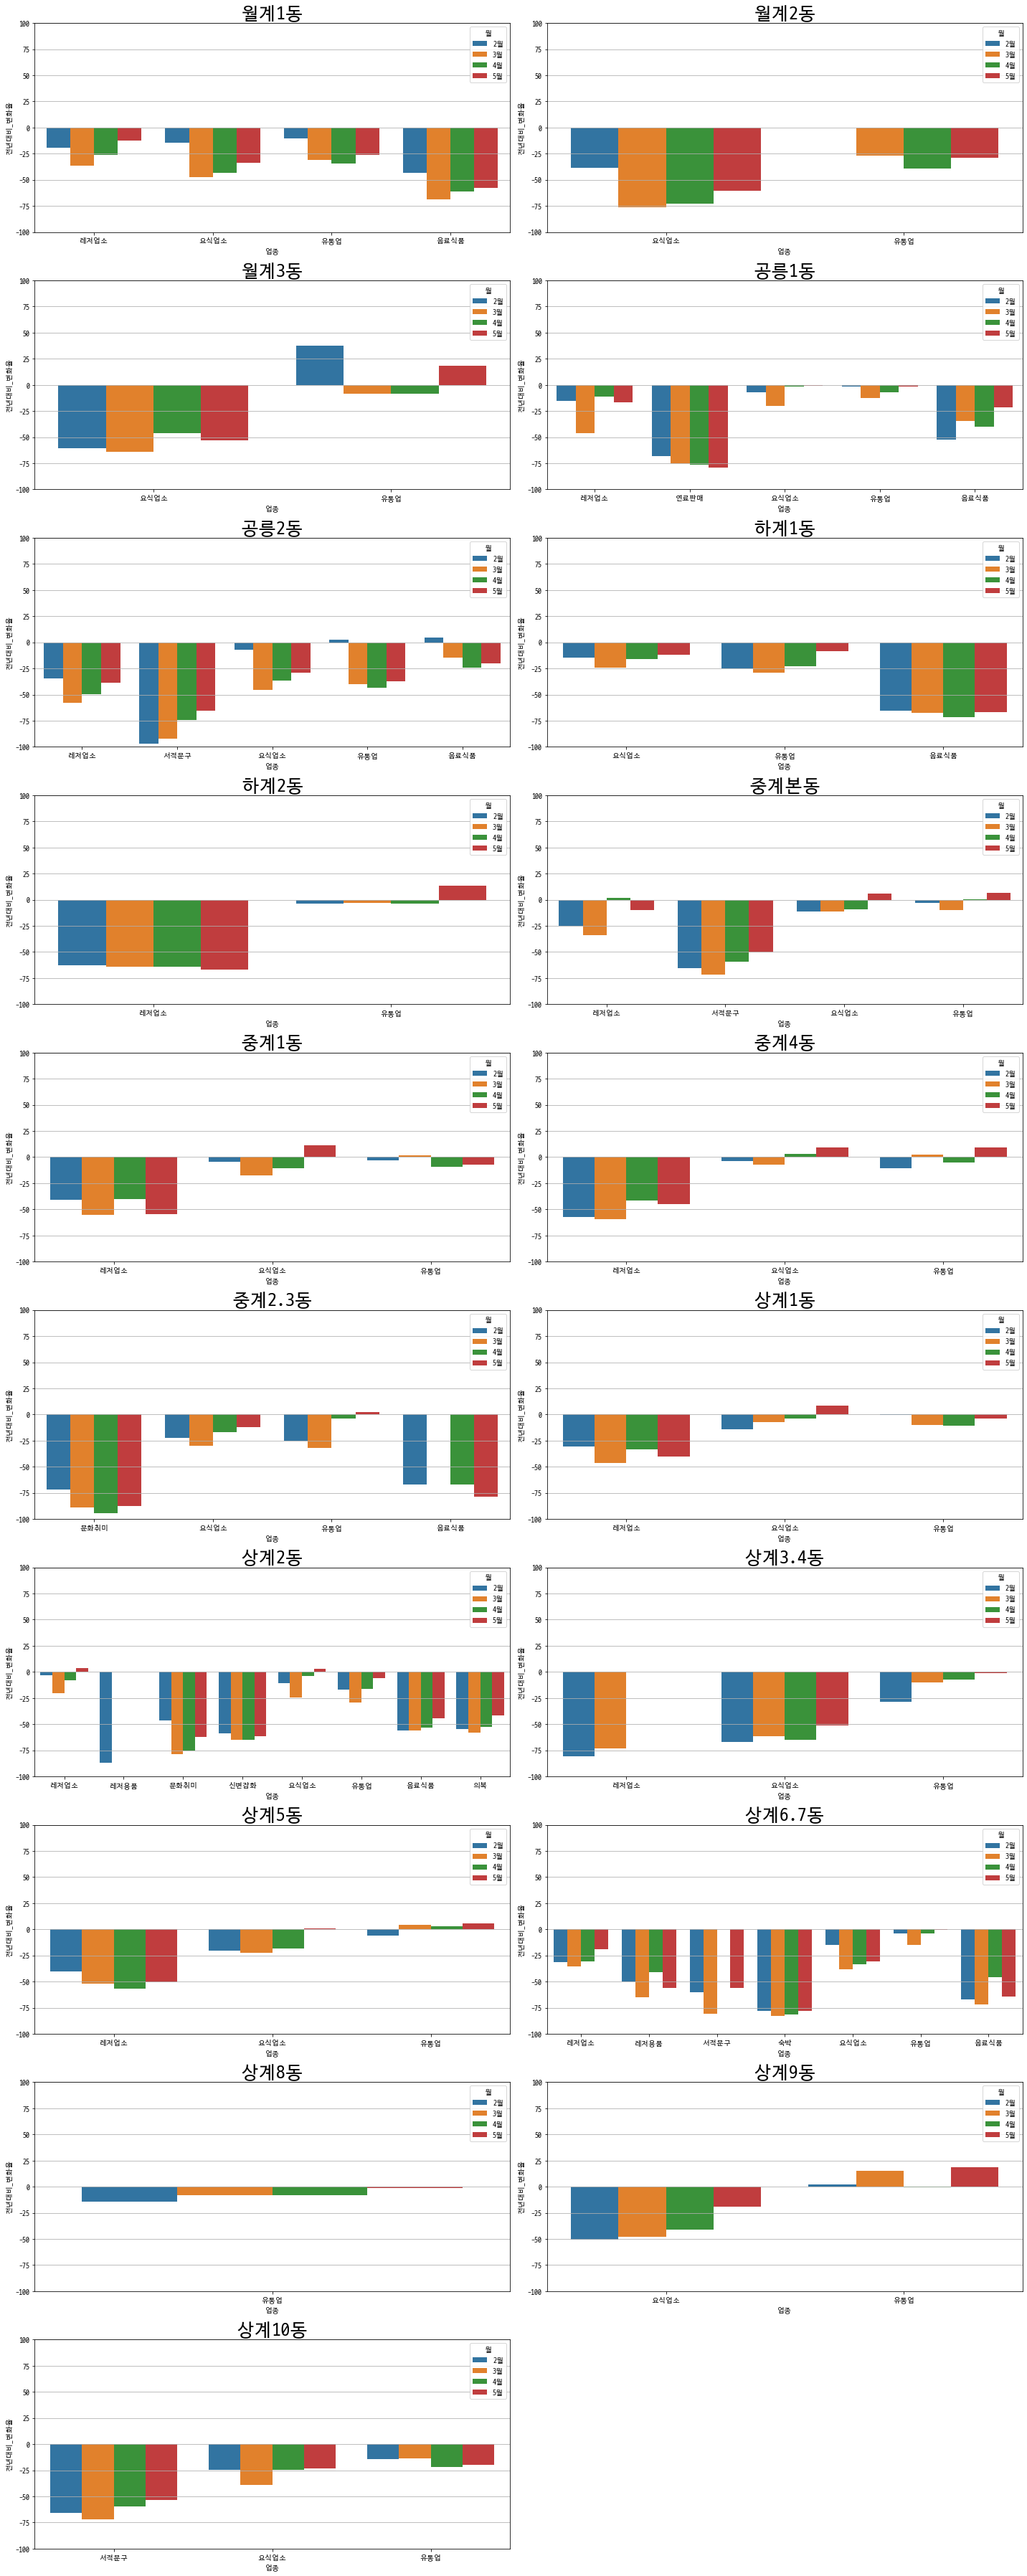

In [208]:
from math import ceil

for gu in ['서울 중구','서울 노원구']:
    makefigure(gu)
    
#신한카드가 가계의 매출전체를 대변할 수는 없지만 경향성을 설명해줄수 있다

서울 노원구 공릉1동
                 이용건수    이용금액
Month 업종   Year              
2     레저업소 2019 187.5  1503.4
           2020 135.4  1278.5
      연료판매 2019 117.6  3377.4
           2020  33.3  1080.0
      요식업소 2019 505.5  9044.9
           2020 508.7  8420.0
      유통업  2019 749.7  4105.6
           2020 694.9  4043.2
      음료식품 2019 114.8  1033.9
           2020  47.8   489.7
3     레저업소 2019 174.6  1641.1
           2020 109.9   887.7
      연료판매 2019 126.4  4077.8
           2020  33.5  1025.6
      요식업소 2019 575.6 10088.8
           2020 518.9  8067.3
      유통업  2019 886.4  4637.1
           2020 687.9  4061.7
      음료식품 2019 125.4   889.9
           2020  53.8   579.9
4     레저업소 2019 166.5  1315.3
           2020  99.5  1171.1
      연료판매 2019 127.9  3744.7
           2020  31.8   894.2
      요식업소 2019 579.2  8986.7
           2020 577.2  8832.0
      유통업  2019 869.4  4410.1
           2020 715.4  4086.8
      음료식품 2019 118.8   935.1
           2020  56.6   560.5
5     레저업소 2019 181.9  1809.

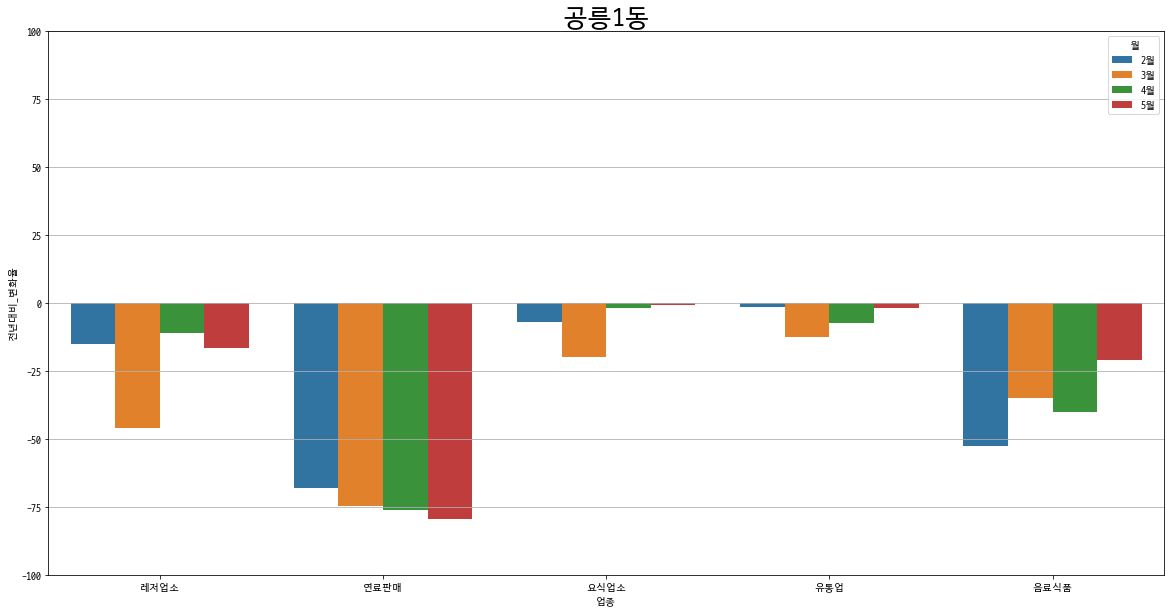

In [209]:
plt.rcParams['figure.figsize'] = [20,10]
gu_dong('서울 노원구','공릉1동')

In [239]:
df_new

,업종,월,전년대비_변화율
0,가구,2월,-6.061999
1,가구,3월,21.221400
2,가구,4월,-108.873475
3,가구,5월,-129.519996
4,가전,2월,21.479938
...,...,...,...
87,주방용구,5월,5.074661
88,직물,2월,32.428609
89,직물,3월,-22.173047
90,직물,4월,-43.919950


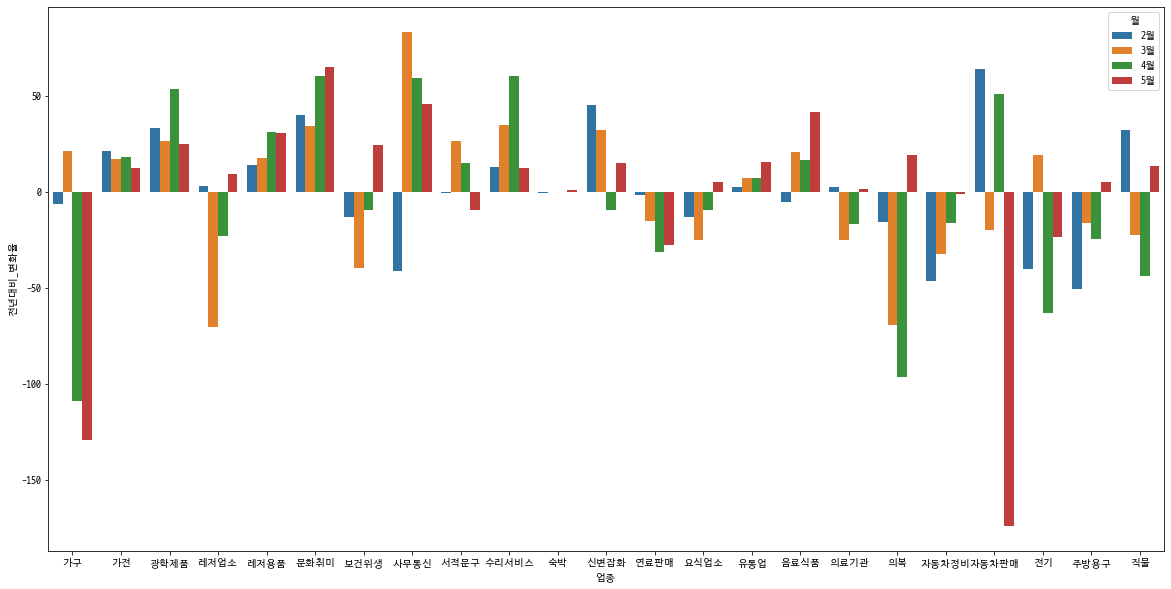

# 노원구 중구의 코로나 이전(2019)과 이후(2020) 업종별 이용건수 이용금액 추이

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

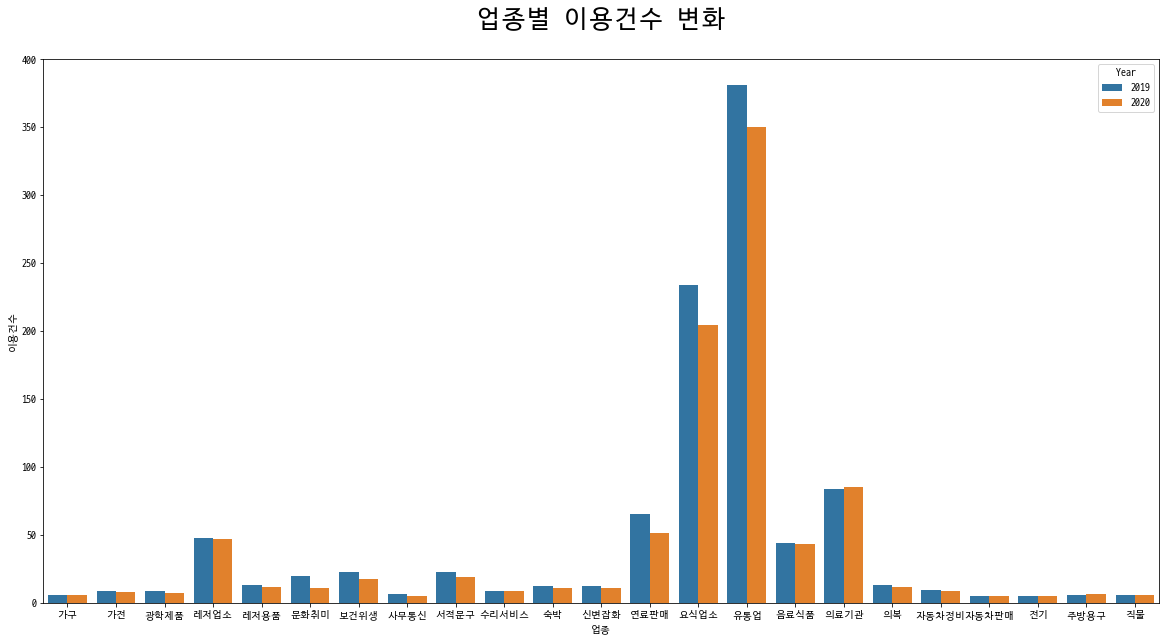

In [283]:

plt.rcParams['figure.figsize'] = [20,10]
g1 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용건수',hue='Year', ci=None)
plt.title('업종별 이용건수 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

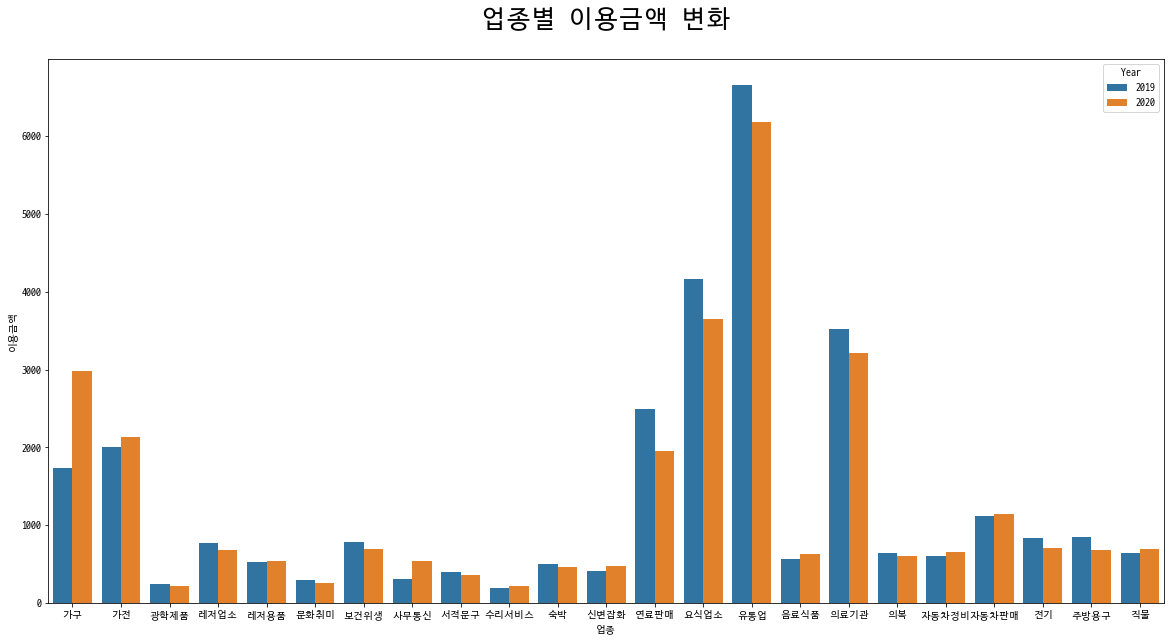

In [284]:
g2 = sns.barplot(data = df_0.loc['서울 노원구'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)
plt.title('업종별 이용금액 변화\n', {'fontsize' : 25, 'color':'black'})
plt.plot

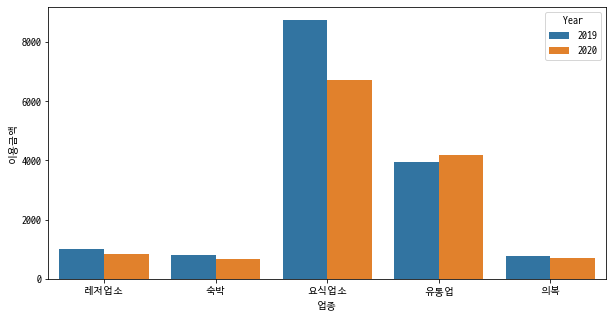

In [338]:
g3 = sns.barplot(data = df_1.loc['서울 노원구','상계6.7동'].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

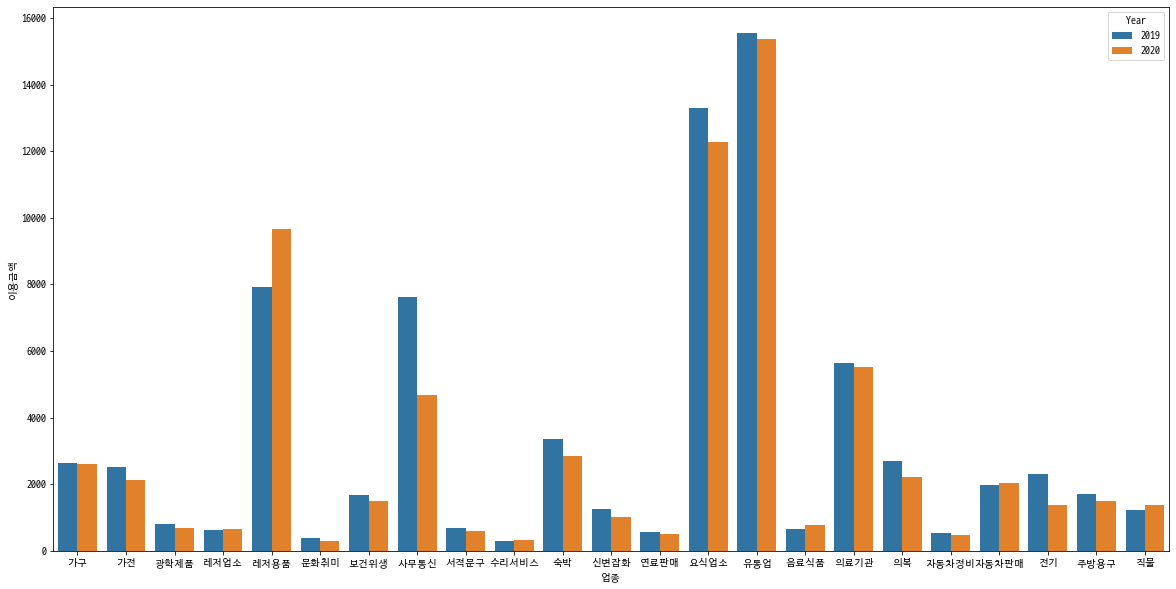

In [52]:
g3 = sns.barplot(data = df_0.loc['서울 중구',5].reset_index(),x='업종', y='이용금액',hue='Year', ci=None)

In [125]:
df_set['동별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['행정동','기준일자'],as_index=True).sum()[['이용건수','이용금액']]
df_set['업종별'] = df_seoul[df_seoul['시_구']=='서울 중구'].groupby(['업종','기준일자'],as_index=True).sum()[['이용건수','이용금액']]

---

In [346]:
import pandas as pd
import pickle
df_corona = pd.read_csv('modeling/data/서울시 확진자 현황.csv', encoding='ANSI')

In [352]:
df_corona.head()

,연번,확진일,환자번호,국적,환자정보,지역,여행력,접촉력,조치사항,상태,이동경로,등록일,수정일,노출여부
0,3867,8.30.,19855,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
1,3866,8.30.,19897,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
2,3865,8.30.,19900,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
3,3864,8.30.,19788,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y
4,3863,8.30.,19797,nan,nan,기타,NaN,확인 중,nan,NaN,확인 중,2020-09-01 9:47,2020-09-01 9:47,Y


In [360]:
df_corona['접촉력'].value_counts()[:30].to_csv('abcd.csv', encoding='cp949')

In [172]:
dfhan = pd.read_pickle('modeling/data/검색어트렌드_한양대_final.pkl')

In [173]:
dfhan

,date,한양대역,가락시장역,가산디지털단지역,강남역,강남구청역,강동역,강동구청역,강변역,개롱역,...,학여울역,한강진역,한성대입구역,합정역,행당역,혜화역,홍대입구역,홍제역,화곡역,화랑대역
0,2020-02-01,18.2,14.3,28.1,175.4,23.1,46.1,32.1,39.7,2.4,...,1.1,22.2,4.1,245.8,1.2,123.2,10.6,4.9,39.3,4.8
1,2020-02-02,18.4,13.7,27.6,180.0,22.7,48.5,31.2,39.7,2.4,...,1.1,24.1,4.2,250.4,1.2,128.5,11.1,4.9,39.3,5.3
2,2020-02-03,18.1,13.5,27.6,184.3,22.5,49.9,31.3,39.8,2.4,...,1.1,24.3,3.9,250.3,1.2,128.1,10.7,4.8,39.8,5.6
3,2020-02-04,18.4,13.2,28.3,188.3,22.8,48.4,31.8,38.2,2.3,...,1.2,23.5,3.8,245.5,1.1,125.5,10.6,4.8,37.7,5.6
4,2020-02-05,19.0,13.0,28.4,191.7,22.6,48.2,31.2,38.3,2.3,...,1.2,23.9,3.7,245.1,1.1,125.7,10.7,4.5,37.3,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2020-08-27,10.8,16.5,24.5,134.3,20.5,65.3,35.5,35.4,2.9,...,0.0,15.3,3.8,194.9,1.2,73.8,6.6,7.7,40.4,7.4
209,2020-08-28,10.1,17.3,24.8,141.1,21.0,70.2,36.9,37.6,2.3,...,0.0,16.0,4.1,208.4,1.2,79.1,6.8,8.2,43.1,8.8
210,2020-08-29,9.3,18.0,24.9,149.5,20.9,77.1,38.3,41.7,2.6,...,0.0,16.9,4.1,225.3,1.3,85.2,7.3,9.1,47.7,9.3
211,2020-08-30,8.4,18.5,23.2,155.0,19.8,86.7,40.2,44.0,2.0,...,0.0,17.3,4.0,231.0,1.1,86.8,7.7,9.9,51.6,11.2


서울시 확진자 중 감염경로라고 볼수 있는 접촉력에대해 보면 밀집된 장소에서 주로 감염이 되었다고 볼수있다.
-> 밀집된장소는 위험하다, 피해야한다